# Replica paper microscopy

### Index

- **Tradicional features**
  - Color moment features
  - Texture features
  - SVM with tradicional features only
- **Deep features**: Coding network (CNN)
  - Create network architecture
  - Is model initily ufreeze?
  - Train
- **Fusion methods**
  - CNMP (multilayer perceptron as fusion method)
  - R feature fusion (manully fixed parameter)
  - KPCA feature fusion
  - SVM feature fusion (SVM as fusion method)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision import *

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import PIL
import cv2
from tqdm import tqdm
from sklearn.svm import SVC                                    # Support vector machine
from sklearn.model_selection import StratifiedKFold            # Stratified cross validation
from sklearn import metrics

# Pytorch dataset

In [2]:
class HistologyDataset(torch.utils.data.Dataset):

	def __init__(self, transforms=False):
		data_dir_hdd = pathlib.Path("E:/Datasets/TFM/histologyDS2828")
		csv_file     = data_dir_hdd / "imageClasses.txt"
		csv_df       = pd.read_csv(csv_file, header=None, delim_whitespace=True, names=['Image', 'Label'])
        
		self.image_dir  = data_dir_hdd / "imgs"
		self.images     = (csv_df["Image"]).values
		self.labels     = (csv_df["Label"]-1).values
		self.labels_map = {0: "conective tissue", 1: "ephitelial tissue", 2: "muscular tissue", 3: "nervous tissue"}
		self.transforms = transforms

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		img_name = self.image_dir / self.images[idx]
		image = PIL.Image.open(img_name)
		if self.transforms: image = self.transforms(image)
		label = self.labels[idx]
		return image, label

mean       = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
std        = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]
train_tmfs =  transforms.Compose([transforms.RandomCrop(420),
                                  transforms.Resize(140),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)])

micro_ds = HistologyDataset()
print("There are", len(micro_ds), "images in the dataset.")

#micro_ds.transforms = train_tmfs
#trainloader = torch.utils.data.DataLoader(micro_ds, batch_size=64, shuffle=True)

There are 2828 images in the dataset.


# Fastai databunch

- With [Stratified Cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels) (cosidering classes)

In [3]:
path     = pathlib.Path("E:/Datasets/TFM/histologyDS2828")
csv_path = path / "imageClasses.txt"
df       = pd.read_csv(csv_path, header=None, delim_whitespace=True, names=['Image', 'Label'])
df       = df.replace({'Label': {1:"Conective", 2:"Ephitelial", 3:"Muscular", 4:"Nervous"}})

###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df.Image.values
y = df.Label.values
train_idxs_fold = []
valid_idxs_fold = []
cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

###################################### Get mean and std
#mean = np.zeros(3)  # float64
#std  = np.zeros(3)  # float64
#for img in tqdm(src):
#    mean += img.data.numpy().mean(axis=(1,2)) # float32
#    std  += img.data.numpy().std(axis=(1,2))
#mean /= 2828
#std  /= 2828
his2828_mean  = [0.842652, 0.554769, 0.578314]
his2828_std   = [0.114894, 0.137445, 0.108943]

##################################### Src data

src  = ImageItemList.from_df(df, path, folder='imgs')
data = (src.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0])
        .label_from_df(cols='Label')
        .transform(get_transforms(flip_vert=True, max_warp=None), size=140)
        .databunch(bs=16)
        .normalize((his2828_mean,his2828_std)))

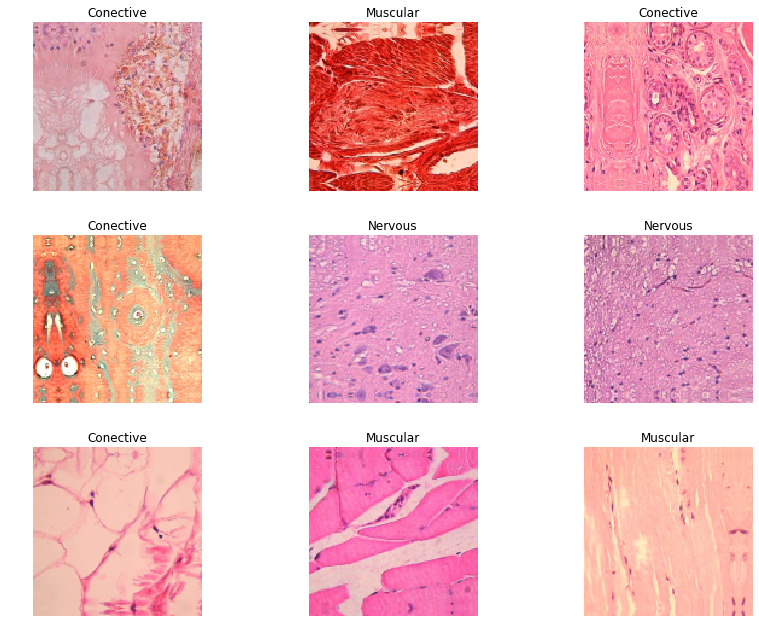

In [4]:
data.show_batch(rows=3, figsize=(12,9))

# Traditional features


### Texture features

1. First acquire the gray-level co-occurrence matrix G (2 distances, 4 angles = 2*4 = 8 matrices)
2. Then, we employ:
   - The angular second moment (ASM)
   - Entropy (ENT)
   - Contrast (CON)
   - Correlation (COR)
   

8 matrices * 4 features each = 32 total features

- [Scikit-image texture features](http://scikit-image.org/docs/0.7.0/api/skimage.feature.texture.html)
- https://stackoverflow.com/questions/50834170/image-texture-with-skimage
- https://stackoverflow.com/questions/51172555/greycomatrix-for-rgb-image
- [Calculating **entropy** from GLCM of an image](https://stackoverflow.com/questions/40919936/calculating-entropy-from-glcm-of-an-image)
- [Understanding texture properties of a grey-level co-occurrence matrix (GLCM)](https://stackoverflow.com/questions/51463436/understanding-texture-properties-of-a-grey-level-co-occurrence-matrix-glcm)


### Color moment features
- https://en.wikipedia.org/wiki/Color_moments
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.moment.html
- https://stackoverflow.com/questions/38182087/third-order-moment-calculation-numpy
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html

In [6]:
from scipy.stats import skew, kurtosis                         # Color feature (3rd moment)
from skimage.feature.texture import greycomatrix, greycoprops  # Texture features
from skimage.measure import shannon_entropy                    # Texture features (entropy)

def texture_features(pil_img):
    
    # Read image in black and white (np array of 2 dimensions)
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # A bit different b&w values
    img = pil_img.convert("L")
    img = np.array(img)

    # Get Gray-Level Co-Occurrence Matrix from the image (2 distances, 4 angles = 2*4 = 8 matrices)
    distances  = [1,2]
    angles     = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degree in radians.
    glcm = greycomatrix(img, distances, angles)
    #print("GLCM shape:", glcm.shape)

    # Get properties from glcm. (Entropy feature is not available in the greycoprops method)
    properties = ['ASM', 'contrast'] #properties = ['ASM', 'contrast', 'correlation']
    some_texture_feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])

    entropy_feat = [shannon_entropy(glcm[:,:,x,y])  for x in range(2)   for y in range(4)]

    return np.hstack([some_texture_feats, entropy_feat])
    
    
def color_features(pil_img):

    np_image = np.array(pil_img)
    mean     = np.mean(np_image, axis=(0,1))                           # First color moment (Mean)
    std      = np.std(np_image, axis=(0,1))                            # Second color moment (std)
    skewness = [skew(np_image[:, :, c].reshape(-1)) for c in range(3)] # Third color moment (Skewness)

    return np.hstack([mean, std, skewness])


def traditional_features(dataset):
    
    num_samples = len(dataset)     # 5
    
    x = np.empty([num_samples, 33]) # 41
    y = np.empty([num_samples])
    
    for i in tqdm(range(num_samples)):
        image = dataset[i][0]
        label = dataset[i][1]
        x[i]  = np.hstack([texture_features(image), color_features(image)])
        y[i]  = label
        
    return x, y

# x,y = traditional_features(micro_ds)
# x,y = traditional_features(skin_ds["test"])
np.save('x.npy', x)
np.save('y.npy', y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [34:04<00:00,  2.28s/it]


# SVM with traditional features

- [scikit-learn](https://scikit-learn.org/stable/modules/svm.html)
- [datacamp](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)
- [dealing with imbalanced classes](https://chrisalbon.com/machine_learning/support_vector_machines/imbalanced_classes_in_svm/)

In [5]:
from sklearn.preprocessing import StandardScaler

x = np.load('traditionalFeats/his_x.npy')
y = np.load('traditionalFeats/his_y.npy')
x = StandardScaler().fit_transform(x)
print("Data shape: x =",x.shape, "y =", y.shape)

accs     = np.array([])
con_mats = np.zeros((4, 4), dtype=int)

for i in range(n_cv_folds):
    
    ########################################################## GET K-FOLD DATA
    train_idxs = train_idxs_fold[i]
    valid_idxs = valid_idxs_fold[i]
    x_train, y_train = x[train_idxs], y[train_idxs]
    x_valid, y_valid = x[valid_idxs], y[valid_idxs]
    
    ########################################################## TRAIN
    # class_weight='balanced' random_state=0
    #svm = SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced') # accuracy: 0.8750937899758103   
    #svm = SVC(kernel='rbf', C=10, gamma=0.1)                          # accuracy: 0.8758142080422531
    #svm = SVC(kernel='rbf', C=100, gamma=0.1)                         # accuracy: 0.8789833541224151
    svm = SVC(kernel='rbf', C=1000, gamma=0.1)                         # accuracy: 0.8793392791435695
    #svm = SVC(kernel='rbf', C=10000, gamma=0.01)                      # accuracy: 0.8589159523325616
    
    svm.fit(x_train, y_train)  # Train the SVM
     
    ########################################################## EVALUATE
    y_pred = svm.predict(x_valid) # Predict the response for test dataset
    print("================================ Fold", i+1)
    acc = metrics.accuracy_score(y_valid, y_pred)
    accs = np.append(accs, acc) #accs.append(acc)
    
    con_mat = metrics.confusion_matrix(y_valid, y_pred)
    con_mats += con_mat
    
    print("Accuracy:", acc)
    print("Confusion matrix:\n", con_mat)
    #print("\tPrecision:", metrics.precision_score(y_valid, y_pred))
    #print("\tRecall:",    metrics.recall_score(y_valid, y_pred))
    #break
    
print("================================ Average folds")
print("Final average accuracy:", accs.mean())
print("Final confusion matrix:\n", con_mats)

Data shape: x = (2828, 33) y = (2828,)
================================ Fold 1
Accuracy: 0.8771929824561403
Confusion matrix:
 [[45  2  2  0]
 [ 0 75  3  3]
 [ 7  0 39  6]
 [ 4  2  6 91]]
================================ Fold 2
Accuracy: 0.8947368421052632
Confusion matrix:
 [[42  2  3  2]
 [ 1 75  2  3]
 [ 5  1 45  1]
 [ 3  5  2 93]]
================================ Fold 3
Accuracy: 0.8701754385964913
Confusion matrix:
 [[39  1  2  7]
 [ 5 70  2  4]
 [ 3  1 45  3]
 [ 5  3  1 94]]
================================ Fold 4
Accuracy: 0.8666666666666667
Confusion matrix:
 [[36  0  7  6]
 [ 2 74  0  5]
 [ 2  3 44  3]
 [ 2  4  4 93]]
================================ Fold 5
Accuracy: 0.8404255319148937
Confusion matrix:
 [[40  1  4  3]
 [ 2 71  4  3]
 [ 7  4 38  2]
 [ 2  6  7 88]]
================================ Fold 6
Accuracy: 0.8829787234042553
Confusion matrix:
 [[41  3  1  3]
 [ 2 72  5  1]
 [ 2  2 45  2]
 [ 5  3  4 91]]
================================ Fold 7
Accuracy: 0.903914590747330

# Coding Network architecture

### Objetivo `79.2`  -> Obtengo `80.3`

- [Custom model with fast.ai](https://forums.fast.ai/t/so-you-want-to-create-your-custom-pipeline-with-fastai/17182/11)


Input size of `3×140×140`

Layer       | Kernel | Stride | Output shape
------------|--------|--------|------------
Convolution | 11×11  |    1   | 32×130×130
Convolution | 11×11  |    1   | 32×120×120
Max pooling | 5×5    |    2   | 32×58×58
Convolution | 9×9    |    1   | 64×50×50
Max pooling | 5×5    |    2   | 64×23×23
Convolution | 8×8    |    1   | 128×16×16
Convolution | 9×9    |    1   | 256×8×8
Convolution | 8×8    |    1   | 256×1×1
Dense       |    -   |    -   | 4×1×1
Softmax     |    -   |    -   | 4×1×1

In [5]:
def conv(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0),
        nn.BatchNorm2d(out_channels),
        # nn.Dropout2d(p=0.05),
        nn.ReLU())

CodingNetwork = nn.Sequential(
	conv(3,  32, kernel_size=11),
	conv(32, 32, kernel_size=11),
	nn.MaxPool2d(kernel_size=5, stride=2, padding=0),
	conv(32, 64, kernel_size=9),
	nn.MaxPool2d(kernel_size=5, stride=2, padding=0),
	conv(64,  128, kernel_size=8),
	conv(128, 256, kernel_size=9),
	conv(256, 256, kernel_size=8),
	Flatten(),
	nn.Linear(256, 4)
)

learn = Learner(data, CodingNetwork, metrics=accuracy)
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 130, 130]   11648      True      
______________________________________________________________________
BatchNorm2d          [16, 32, 130, 130]   64         True      
______________________________________________________________________
ReLU                 [16, 32, 130, 130]   0          False     
______________________________________________________________________
Conv2d               [16, 32, 120, 120]   123936     True      
______________________________________________________________________
BatchNorm2d          [16, 32, 120, 120]   64         True      
______________________________________________________________________
ReLU                 [16, 32, 120, 120]   0          False     
______________________________________________________________________
MaxPool2d            [16, 32, 58, 58]     0          False     
______________________________________________________________

# Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


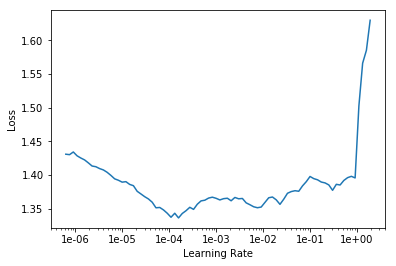

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(45, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.178862,1.114397,0.526316
2,1.121192,1.028897,0.596491
3,1.132525,1.265788,0.414035
4,1.101816,1.046518,0.550877
5,1.128229,1.135974,0.522807
6,1.100832,1.202511,0.442105
7,1.107533,1.046004,0.571930
8,1.091613,0.959201,0.596491
9,1.096202,1.095099,0.522807
10,1.113045,1.215085,0.400000


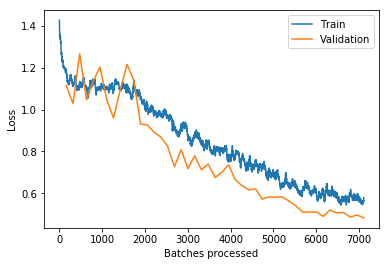

In [8]:
learn.recorder.plot_losses()

In [9]:
learn.save("codNet-45-epochs")

## Test

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

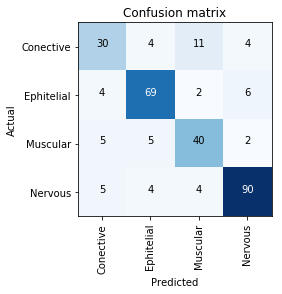

In [12]:
interp.plot_confusion_matrix()

# Save high (cnn) features

In [13]:
src  = ImageItemList.from_df(df, path, folder='imgs')
data = (src.no_split()
        .label_from_df(cols='Label')
        .transform(([crop_pad(size=420)],[]), size=140)
        .databunch(bs=16)
        .normalize((his2828_mean, his2828_std)))

learn.load("codNet-45-epochs");

In [14]:
def high_features(dataset, model):
    
    num_samples = len(dataset)
    h_feats = np.empty([num_samples, 256])
    
    model.eval()
    model = model[:-1]
    
    for i in tqdm(range(num_samples)):
        
        img_tnsr   = dataset[i][0].data.cuda()[None,:]         # [1, 3, 140, 140] cuda tensor
        h_feats[i] = model(img_tnsr)[0].cpu().detach().numpy() # [256] cpu numpy

    return h_feats

h_feats = high_features(data.train_ds, learn.model)
np.save('features/hist_x_high.npy', h_feats)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2828/2828 [01:08<00:00, 41.15it/s]


# ...........................................Fusion methods..............................................

Low  level features = `33` (deberían ser `41`). High level features = `256`

- [ ] CNMP (multilayer perceptron as fusion method)
- [ ] R feature fusion (manully fixed parameter λ) `λ·LF + (1−λ)·HF`
- [ ] KPCA feature fusion (kernel principal component analysis with the RBF kernal) (lento)
- [ ] SVM feature fusion (SVM as fusion method)

In [15]:
from sklearn import preprocessing

x_low  = np.load('features/hist_x_low.npy')
x_high = np.load('features/hist_x_high.npy')
y      = np.load('features/hist_y.npy')

#low_scaled = preprocessing.scale(low)
x_low = preprocessing.StandardScaler().fit_transform(x_low) # Normalice
x_fusion = np.concatenate((x_low, x_high), axis=1)


############################## Split in train-val
train_idxs = train_idxs_fold[0]
valid_idxs = valid_idxs_fold[0]
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid =x_fusion[valid_idxs], y[valid_idxs]

print("Low features:\tShape:", x_low.shape,   "\t Min:", x_low.min(), ",\t Max:", x_low.max())
print("High features:\tShape:", x_high.shape, "\t Min:", x_high.min(), ",\t Max:", x_high.max())
print("Fusion feats:\tShape:", x_fusion.shape, "\t Min:", x_fusion.min(), ",\t Max:", x_fusion.max())

Low features:	Shape: (2828, 33) 	 Min: -11.04875517255985 ,	 Max: 12.67794746024392
High features:	Shape: (2828, 256) 	 Min: 0.0 ,	 Max: 3.641989231109619
Fusion feats:	Shape: (2828, 289) 	 Min: -11.04875517255985 ,	 Max: 12.67794746024392


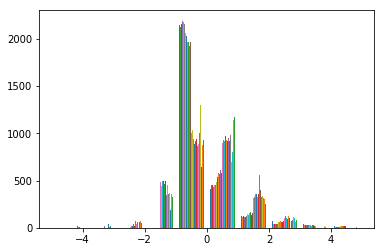

In [36]:
#import matplotlib.pyplot as plt
plt.hist(x_low, range=(-5,5));

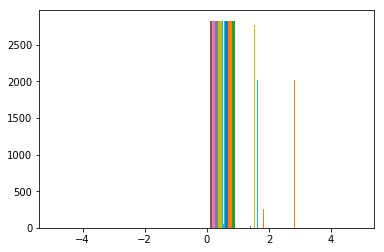

In [38]:
plt.hist(x_high, range=(-5,5));

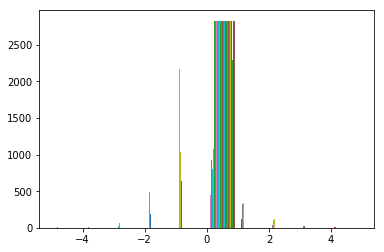

In [37]:
plt.hist(x_fusion, range=(-5,5));

# Fusion: R
### Objetivo `86.3` -> Obtengo `77.8`

In [132]:
from sklearn.linear_model import LogisticRegression

#from sklearn.neural_network import MLPClassifier
#model = MLPClassifier(hidden_layer_sizes=(), max_iter=10000, validation_fraction=0)

model = LogisticRegression(C=1e6, solver='lbfgs', multi_class='multinomial', max_iter=10000, random_state=0)
model.fit(x_train, y_train)

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [133]:
y_pred  = model.predict(x_valid) # Predict the response for test dataset
acc     = metrics.accuracy_score(y_valid, y_pred)
con_mat = metrics.confusion_matrix(y_valid, y_pred)
print("Accuracy:", acc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.7789473684210526
Confusion matrix:
 [[35  4  6  4]
 [ 2 69  2  8]
 [ 3  9 33  7]
 [ 4  9  5 85]]


# Fusion: MLP
### Objetivo `90.2` -> Obtengo `89.8`

In [47]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(170), max_iter=1000, validation_fraction=0, random_state=0) # 150, 200 hl works good
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=170, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0, verbose=False, warm_start=False)

In [48]:
y_pred  = model.predict(x_valid) # Predict the response for test dataset
acc     = metrics.accuracy_score(y_valid, y_pred)
con_mat = metrics.confusion_matrix(y_valid, y_pred)
print("Accuracy:", acc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.8982456140350877
Confusion matrix:
 [[44  0  2  3]
 [ 1 74  0  6]
 [ 2  4 43  3]
 [ 5  0  3 95]]


# Fusion: SVM
### Objetivo `81.1`  -> Obtengo `89.1`

In [49]:
model = SVC(kernel='rbf', C=10, gamma=0.1)
model.fit(x_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
y_pred  = model.predict(x_valid) # Predict the response for test dataset
acc     = metrics.accuracy_score(y_valid, y_pred)
con_mat = metrics.confusion_matrix(y_valid, y_pred)
print("Accuracy:", acc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.8912280701754386
Confusion matrix:
 [[40  2  4  3]
 [ 3 76  1  1]
 [ 3  3 41  5]
 [ 3  1  2 97]]


In [136]:
model = SVC(kernel='linear', C=10, gamma=0.1)
model.fit(x_train, y_train)
y_pred  = model.predict(x_valid) # Predict the response for test dataset
acc     = metrics.accuracy_score(y_valid, y_pred)
con_mat = metrics.confusion_matrix(y_valid, y_pred)
print("Accuracy:", acc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.7192982456140351
Confusion matrix:
 [[30  7  6  6]
 [10 60  3  8]
 [ 8  3 35  6]
 [ 5 12  6 80]]


# Fusion: KPCA
PCA with RBF kernel
### Objetivo `84.9`  -> Obtengo `70.5`

In [139]:
from sklearn.decomposition import KernelPCA

kpca         = KernelPCA(kernel="rbf")#, gamma=10)
x_train_kpca = kpca.fit_transform(x_train)

model = SVC(kernel='linear', C=10, gamma=0.1) # Linear SVM
model.fit(x_train_kpca, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [140]:
x_valid_kpca = kpca.transform(x_valid)
y_pred       = model.predict(x_valid_kpca)
acc          = metrics.accuracy_score(y_valid, y_pred)
con_mat      = metrics.confusion_matrix(y_valid, y_pred)
print("Accuracy:", acc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.7052631578947368
Confusion matrix:
 [[29  7  7  6]
 [ 8 61  2 10]
 [ 9  8 29  6]
 [ 7 10  4 82]]


# Original parper results
- [plot a confusion matrix](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)

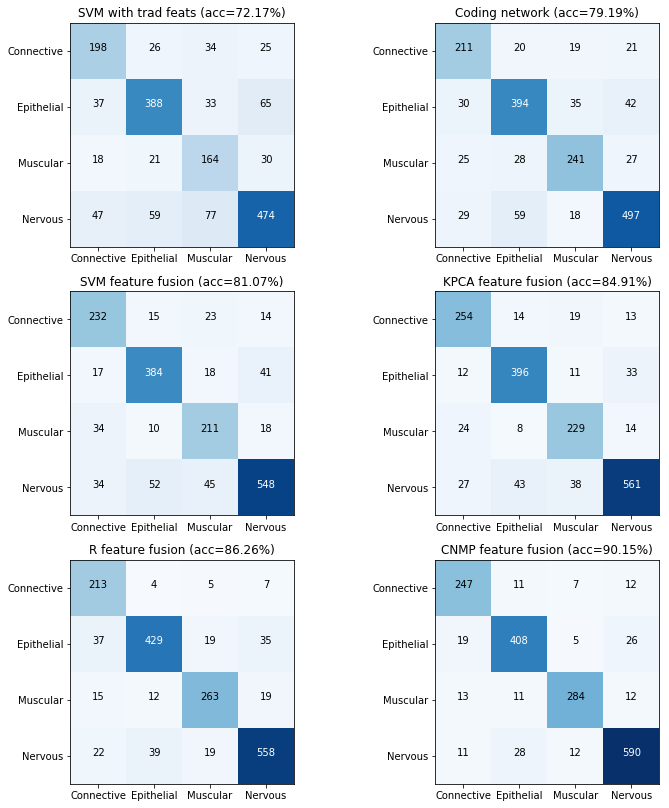

In [143]:
cm1 = np.array([[198,  26,  34,  25],
                [ 37, 388,  33,  65],
                [ 18,  21, 164,  30],
                [ 47,  59,  77, 474]])

cm2 = np.array([[211,  20,  19,  21],
                [ 30, 394,  35,  42],
                [ 25,  28, 241,  27],
                [ 29,  59,  18, 497]])

cm3 = np.array([[232,  15,  23,  14],
                [ 17, 384,  18,  41],
                [ 34,  10, 211,  18],
                [ 34,  52,  45, 548]])

cm4 = np.array([[254,  14,  19,  13],
                [ 12, 396,  11,  33],
                [ 24,   8, 229,  14],
                [ 27,  43,  38, 561]])

cm5 = np.array([[213,   4,   5,   7],
                [ 37, 429,  19,  35],
                [ 15,  12, 263,  19],
                [ 22,  39,  19, 558]])

cm6 = np.array([[247,  11,   7,  12],
                [ 19, 408,   5,  26],
                [ 13,  11, 284,  12],
                [ 11,  28,  12, 590]])



con_mats = [cm1, cm2, cm3, cm4, cm5, cm6]
labels   = ["Connective", "Epithelial", "Muscular", "Nervous"]
titles   = ['SVM with trad feats',
            'Coding network',
            'SVM feature fusion',
            'KPCA feature fusion',
            'R feature fusion',
            'CNMP feature fusion']
accuracies = []

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,14))

for i, ax in enumerate(axes.flat):
    con_mat  = con_mats[i]
    accuracy = np.trace(con_mat) / float(np.sum(con_mat))
    accuracies.append(accuracy)
    cmap     = plt.get_cmap('Blues')
    
    im = ax.imshow(con_mat, cmap=cmap, vmin=0, vmax=590)
    ax.set_title(titles[i]+" (acc={:0.2f}%)".format(accuracy*100))
    
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks); ax.set_xticklabels(labels)#, rotation=45)
    ax.set_yticks(tick_marks); ax.set_yticklabels(labels)
        
    thresh = con_mat.max() / 2
    for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
        ax.text(j, i, "{:,}".format(con_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black")
        
    #ax.set_ylabel('Actual')
    #ax.set_xlabel('Predicted')
        
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.tight_layout()
plt.show()

In [144]:
assert(np.sum(cm1)==np.sum(cm2)==np.sum(cm3)==np.sum(cm4)==np.sum(cm5)==np.sum(cm6))
np.sum(cm1)/2828

0.5997171145685997

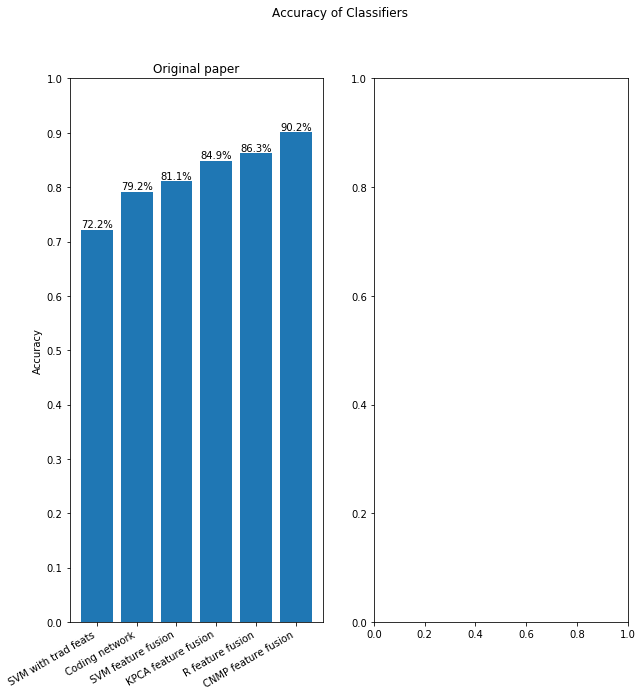

In [153]:
model_names   = ['SVM1', 'CN', 'SVM2', 'KPCA', 'R', 'CNMP']
model_numbers = np.arange(len(titles))

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#fig, ax  = plt.subplots(figsize=(4,10))
bar_char = ax.bar(model_numbers, accuracies)
fig.suptitle('Accuracy of Classifiers')

ax.set_title('Original paper')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticks(model_numbers)
#ax.set_xticklabels(model_names)
ax.set_xticklabels(titles, rotation=30, ha='right')

for x,y in zip(model_numbers, accuracies):
    ax.text(x, y, "{:0.1f}%".format(y*100), ha='center', va='bottom')

    
plt.show()

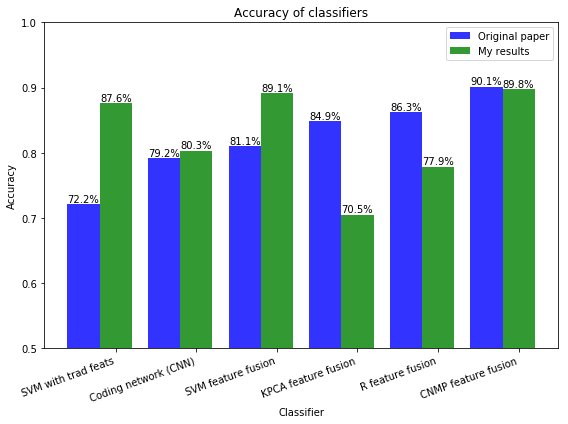

In [199]:
# data to plot
titles   = ['SVM with trad feats',
            'Coding network (CNN)',
            'SVM feature fusion',
            'KPCA feature fusion',
            'R feature fusion',
            'CNMP feature fusion']
acc_paper   = [0.7216, 0.7918, 0.8107, 0.8490, 0.8626, 0.9015]
acc_mine    = [0.8762, 0.8035, 0.8912, 0.7052, 0.7789, 0.8982]
n_models = 6

 
# create plot
fig, ax = plt.subplots(figsize=(8,6))
index = np.arange(n_models)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, acc_paper, bar_width,
alpha=opacity,
color='b',
label='Original paper')
 
rects2 = plt.bar(index + bar_width, acc_mine, bar_width,
alpha=opacity,
color='g',
label='My results')

for x,y in zip(index, acc_paper):
    plt.text(x, y, "{:0.1f}%".format(y*100), ha='center', va='bottom')
    

for x,y in zip(index + bar_width, acc_mine):
    plt.text(x, y, "{:0.1f}%".format(y*100), ha='center', va='bottom')
    
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of classifiers')
plt.ylim(0.5,1)
plt.xticks(index + bar_width, titles, rotation=20, ha='right')
plt.legend()
 
plt.tight_layout()
plt.show()